In [8]:
import torch
import matplotlib.pyplot as plt
from torchvision.datasets import MNIST
from sklearn.metrics import ConfusionMatrixDisplay

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [9]:
# build the dataset (train, validation and test)
def get_mnist(n_val=10000):
    train = MNIST(root = '.', train = True, download = True)
    test = MNIST(root = '.', train = False, download = True)
    x_train, x_test = train.data/255, test.data/255
    x_train = x_train.reshape(x_train.shape[0], -1)
    x_test = x_test.reshape(x_test.shape[0], -1)
    y_train = torch.nn.functional.one_hot(train.targets)
    y_test = torch.nn.functional.one_hot(test.targets)
    data_dict = {}
    data_dict['x_train'] = x_train[:-n_val]
    data_dict['y_train'] = y_train[:-n_val]
    data_dict['x_val'] = x_train[-n_val:]
    data_dict['y_val'] = y_train[-n_val:]
    data_dict['x_test'] = x_test
    data_dict['y_test'] = y_test
    return data_dict

data_dict = get_mnist()

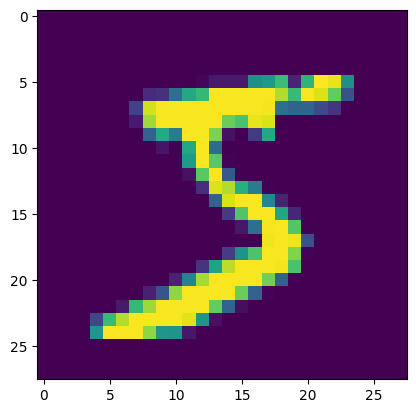

In [10]:
plt.imshow(data_dict['x_train'][0].reshape(28, 28))
plt.show()

In [11]:
class FFNN(object):
    def __init__(self, learning_rate, n_iters, batch_size, hidden_size, device, dtype=torch.float32):
        self.learning_rate = learning_rate
        self.n_iters = n_iters
        self.batch_size = batch_size
        self.hidden_size = hidden_size
        self.device = device
        self.dtype = dtype
        self.history = {}
        self.history['train_acc'], self.history['val_acc'], self.history['loss'] = [], [], []
    
    def sigmoid(self, x):
        x = torch.mul(x, -1)
        x = torch.exp(x)
        x = torch.add(x, 1)
        x = torch.pow(x, -1)
        return x

    def train(self, x, y, x_val, y_val, verbose=1):
        n_train = x.shape[0]
        n_val = x_val.shape[0]
        input_size = x.shape[1]
        num_classes = y.shape[1]

        # 784 inputs and 32 outputs
        self.W1 = torch.randn(input_size, self.hidden_size, dtype=self.dtype, device=self.device) * 0.01
        # 32 inputs and 10 outputs
        self.W2 = torch.randn(self.hidden_size, num_classes, dtype=self.dtype, device=self.device) * 0.01

        for i in range(self.n_iters):
            loss = 0
            data = getBatch(x, y, self.batch_size)
            for x_batch, y_batch in data:
                # forward pass
                hidden = torch.empty(size=[self.batch_size, self.hidden_size])
                output = torch.empty(size=[self.batch_size, num_classes])
                if (x_batch.shape[0] == 0):
                    break # workaround
                for i in range(self.batch_size):
                    hidden[i] = self.sigmoid((torch.matmul(x_batch[i], self.W1)))
                    output[i] = self.sigmoid((torch.matmul(hidden[i], self.W2)))

                # error
                output_error = y_batch - output # y - y_hat

                # MSE loss
                loss += torch.sum(torch.pow(output_error, 2)) / self.batch_size
                # [100, 10]
                delta_output = output_error * (output * (1 - output))
                # [100, 32]
                delta_hidden = torch.empty(size=[self.batch_size, self.hidden_size])
                for i in range(self.batch_size):
                    for j in range(self.hidden_size):
                        delta_hidden[i][j] = (delta_output[i] * self.W2[j] * (hidden[i][j] * (1 - hidden[i][j]))).sum()

                # backward prop
                for i in range(self.batch_size):
                    self.W1 += x_batch[i].outer(delta_hidden[i]) * self.learning_rate
                    self.W2 += hidden[i].outer(delta_output[i]) * self.learning_rate
            
            # training history
            y_pred = self.predict(x)
            train_acc = torch.sum(torch.argmax(y, dim=1) == y_pred) / n_train
            self.history['train_acc'].append(train_acc)
            self.history['loss'].append(loss)
            
            y_pred = self.predict(x_val)
            val_acc = torch.sum(torch.argmax(y_val, dim=1) == y_pred) / n_val
            self.history['val_acc'].append(val_acc)
            if verbose:
                print('epoch %d, loss %.4f, train acc %.3f, validation acc %.3f'
                  % (i + 1, loss, train_acc, val_acc))
    
    def predict(self, x):
        # x is n elements of 28x28 images (n x 784)
        # y_pred contains n integer result types, each from 0-9
        y_pred = torch.empty(x.shape[0], dtype=torch.int)
        for i, xi in enumerate(x):
            # propopagate to hidden layers via W1
            # W1 is a matrix with 784 inputs and 32 outputs
            hidden_layer_activations = self.sigmoid((torch.matmul(xi, self.W1)))
            # 32 activations in hidden layer
            output_activations = self.sigmoid((torch.matmul(hidden_layer_activations, self.W2)))
            y_pred[i] = torch.argmax(output_activations)
        return y_pred

def getBatch(x, y, batch_size):
    n_epoch = x.shape[0] // batch_size
    for i in range(n_epoch):
        x_batch = x[i * batch_size : (i+1) * batch_size]
        y_batch = y[i * batch_size : (i+1) * batch_size]
        yield x_batch, y_batch
    x_batch = x[(i+1) * batch_size:]
    y_batch = y[(i+1) * batch_size:]    
    yield x_batch, y_batch

In [12]:
model1 = FFNN(learning_rate=0.01, n_iters=6, batch_size=100, hidden_size=32, device=device)
model1.train(data_dict['x_train'].to(device), data_dict['y_train'].to(device), data_dict['x_test'].to(device), data_dict['y_test'].to(device), verbose=True)

####################################################################################################

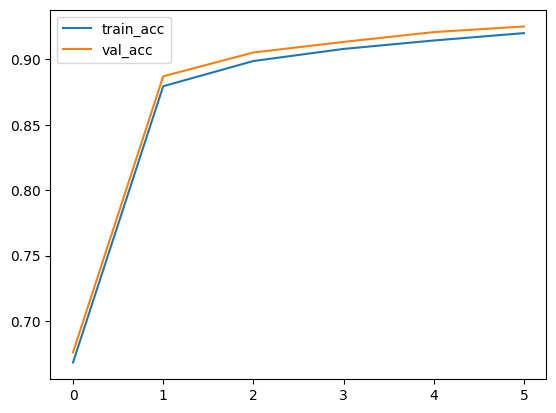

In [ ]:
plt.plot(model1.history['train_acc'], label='train_acc')
plt.plot(model1.history['val_acc'], label='val_acc')
plt.legend()
plt.show()

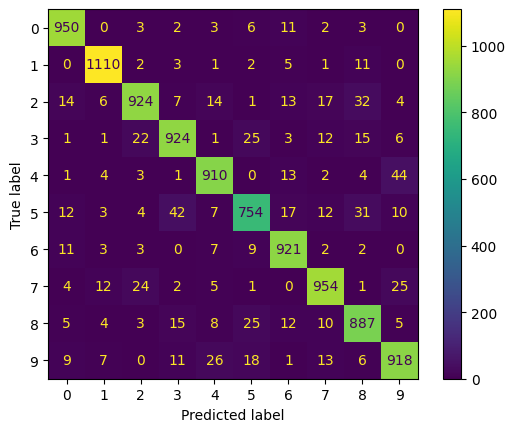

In [ ]:
# testing
y_pred = model1.predict(data_dict['x_test'].to(device))
y_test_t = data_dict['y_test'].to(device)
y_test = torch.empty(y_pred.shape, dtype=torch.int)
for i in range(y_test_t.shape[0]):
    y_test[i] = torch.argmax(y_test_t[i])

disp = ConfusionMatrixDisplay.from_predictions(
        y_test,
        y_pred,
        display_labels=['0', '1', '2', '3', '4', '5', '6', '7', '8', '9'],
    )